<hr style="height: 4px; color: #839D2D; width: 100%; ">

# <font color='#61210B'>Formation OpenClassRooms   -   Parcours DATA ANALYST</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

## <font color='blue'>Projet IX - Prédiction de la demande en Electricité (Région ARA)</font>



### Mission 1 - Data Import/Cleaning - Analyse Descriptive
### Mission 2 - Correction de l'effet de T° (du au chauffage) sur les données "conso mensuelles"
### Mission 3 - Désaisonnalisation (avec Moyennes Mobiles)
### Mission 4 - Prévisions de la Consommation
>   * Méthode Hold-Winters
>   *  Methode SARIMA  

<br>  
<font color="blue" size=4><b>Les données sont issues de</b></font> :
- RTE Réseau de Transport de l'Electricité - (<a href="http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement">Consommation Electrique Mensuelle</a>)  
- Cegibat (<a href="https://cegibat.grdf.fr/simulateur/calcul-dju">Données Météo DJU(correction effet T°)</a>)  

<br>  
<font color="blue" size=4><b>DataFrames pandas utilisés et critères de téléchargement</b></font> :
* <font color='#8A0808'>DataFrame <strong>ara</strong></font> : Consommation Electrique Mensuelle - Rhône Alpes Auvergne - Janvier 2014/Juin 2019  
1ère mise en forme avec Excel.  


* <font color='#8A0808'>DataFrame <strong>dju</strong></font> : Degré Jour Unifié

<hr style="height: 0.5px; color: blue; width: 100%; ">  
<font color='darkblue'>Date : <b>9 Septembre 2019</b>  
<br>Auteur : <b>Frédéric Boissy</b></font>  

<hr style="height: 4px; color: #839D2D; width: 100%; ">


In [1]:
# # Github
# if(!require(devtools)) install.packages("devtools")
# devtools::install_github("sinhrks/ggfortify")
# install.packages('forecast', dependencies = TRUE)
# install.packages('caschrono', dependencies = TRUE)
# install.packages('readxl', dependencies = TRUE)

In [2]:
# -*- coding: utf8 -*-
library(dplyr) # très utile
library(reshape2) # dcast, melt
library(ggfortify) # autoplot
library(xts) # Séries temporelles
library(lubridate) # le choix dans la date
library(forecast) # Acf, Pacf, ma
library(tseries) # adf.test
library(caschrono) # t_stat
library(ggplot2)
library(readxl)
options(repr.plot.width=12, repr.plot.height=3)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



In [3]:
getwd()
setwd("D:/DATA_ANALYST/WORK/PJ9/Data/R")

[1] "D:/DATA_ANALYST/WORK/PJ9"

<hr style="height: 2px; width: 100%; ">

# Téléchargement des données

Vous téléchargerez les données de consommation d'électricité mensuelles à partir de cette page : http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement

<img src="DATA/images/RTE_data_site.png" align="center">

Date,Conso
01.01.2014,6693
01.02.2014,6013
01.03.2014,5965
01.04.2014,5139
01.05.2014,4858


      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
2013                                                        6693
2014 6013 5965 5139 4858 4621 4823 4299 4716 5085 5643 6705 7123
2015 6683 6326 5283 4839 4848 5124 4508 4797 5606 5829 6269 6913
2016 6482 6641 5431 4974 4674 4815 4435 4709 5475 6088 7130 8014
2017 6086 5969 5180 5006 4778 4875 4515 4776 5158 6331 7226 6776
2018 6918 6747 5141 4876 4716 4990 4561 4657 5260 5962 6685 7599

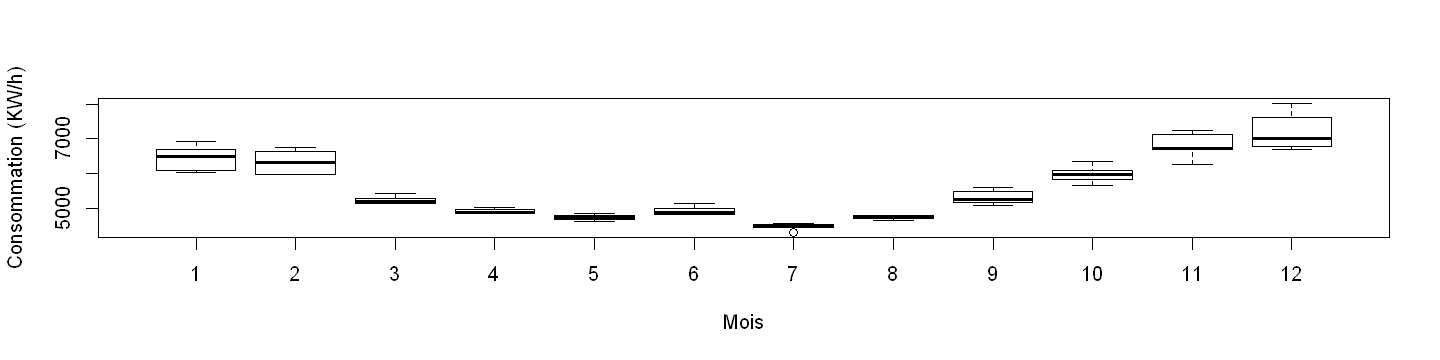

In [4]:
ARA0 = (read.csv("eco2mix-regional-cons-def_M.csv",sep=";",header=T)
        # Pour correspondre aux données DJU, on restreint la série sur une zone géographique
        %>% filter(Territoire=="Auvergne-Rhône-Alpes")
        # Seule les données dites définitives sont utilisées
        %>% filter(Qualité=="Données définitives")
        %>% select(c(Date, Consommation.totale))         
        %>% na.omit
        %>% setNames(c("Date","Conso")))
head(ARA0, 5)
# Conversion en série temporelle format xts
ARA0 = (xts(ARA0$Conso,order.by=as.Date(ARA0$Date,"%d.%m.%Y")) )# %>% apply.monthly(mean))
# Création d'un index base mensuelle
index(ARA0) <- floor_date(index(ARA0),"month")
# reconversion en timeserie
ARA0 = ts(ARA0,frequency=12,start=c(2013, 12), end=c(2018,12))
ARA0
# et voilà!
boxplot(ARA0 ~ cycle(ARA0),xlab="Mois",ylab="Consommation (KW/h)")

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : https://cegibat.grdf.fr/simulateur/calcul-dju

Le degré jour unifié (DJU) est la différence entre la température extérieure et une température de référence

<img src="DATA/images/cegibat_params.png" width="600" align="left">

year,variable,value
2019,X1,445.9
2018,X1,301.4
2017,X1,532.2
2016,X1,344.0
2015,X1,419.5


       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
2013                                                                   334.1
2014 290.1 244.4 134.1  82.9   3.0   8.8   3.7  20.2  73.7 222.8 393.9 419.5
2015 393.2 276.1 143.4  49.1   0.0   0.0   0.0  50.2 188.6 249.5 289.7 344.0
2016 319.4 318.4 176.8  93.7   8.3   4.4   0.3  14.5 191.2 283.1 466.4 532.2
2017 271.1 205.4 180.8  80.7   3.7   1.3   2.0  49.1 110.0 328.5 409.8 301.4
2018 430.4 291.8  97.8  47.2   0.3   0.0   1.5  13.3 122.8 264.9 343.7 445.9

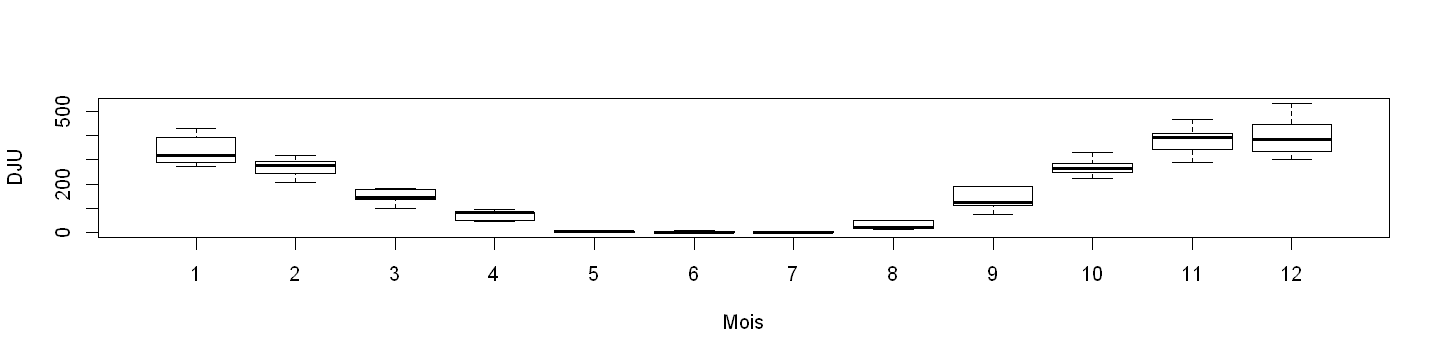

In [5]:
# Le datasource CEGIBAT permet uniquement d'exporter des données géolocalisées
# Plutôt que de devoir créer un utilitaire de requêtage puis consolidation (hors sujet)
# on concentre l'étude sur la région Nouvelle-Aquitaine.
# Autre option : acheter les DJU mensuels nationaux à Météo-France
DJU = (read.csv("dju_lyon_2012-2019.csv",sep=";",header=T)
        %>%  melt(id.vars = 'year')
        %>% na.omit
        %>% filter(value>=0)
        %>% filter(year>2013))
head(DJU, 5)
# Création d'un index base mensuelle
idx = floor_date(parse_date_time(paste(DJU$year,DJU$variable),"%Y %m"),"month")
# Conversion de la série en série temporelle format xts 
DJU = (xts(DJU$value,order.by=idx))
# reconversion en timeserie pour intégration avec Forecast
DJU = ts(DJU,frequency=12,start=c(2013, 12), end=c(2018,12))
DJU
# et voilà!
boxplot(DJU ~ cycle(DJU),xlab="Mois",ylab="DJU")

<hr style="height: 2px; width: 100%; ">

# Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

In [6]:
ARA0
DJU

      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
2013                                                        6693
2014 6013 5965 5139 4858 4621 4823 4299 4716 5085 5643 6705 7123
2015 6683 6326 5283 4839 4848 5124 4508 4797 5606 5829 6269 6913
2016 6482 6641 5431 4974 4674 4815 4435 4709 5475 6088 7130 8014
2017 6086 5969 5180 5006 4778 4875 4515 4776 5158 6331 7226 6776
2018 6918 6747 5141 4876 4716 4990 4561 4657 5260 5962 6685 7599

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
2013                                                                   334.1
2014 290.1 244.4 134.1  82.9   3.0   8.8   3.7  20.2  73.7 222.8 393.9 419.5
2015 393.2 276.1 143.4  49.1   0.0   0.0   0.0  50.2 188.6 249.5 289.7 344.0
2016 319.4 318.4 176.8  93.7   8.3   4.4   0.3  14.5 191.2 283.1 466.4 532.2
2017 271.1 205.4 180.8  80.7   3.7   1.3   2.0  49.1 110.0 328.5 409.8 301.4
2018 430.4 291.8  97.8  47.2   0.3   0.0   1.5  13.3 122.8 264.9 343.7 445.9

R2,0.95


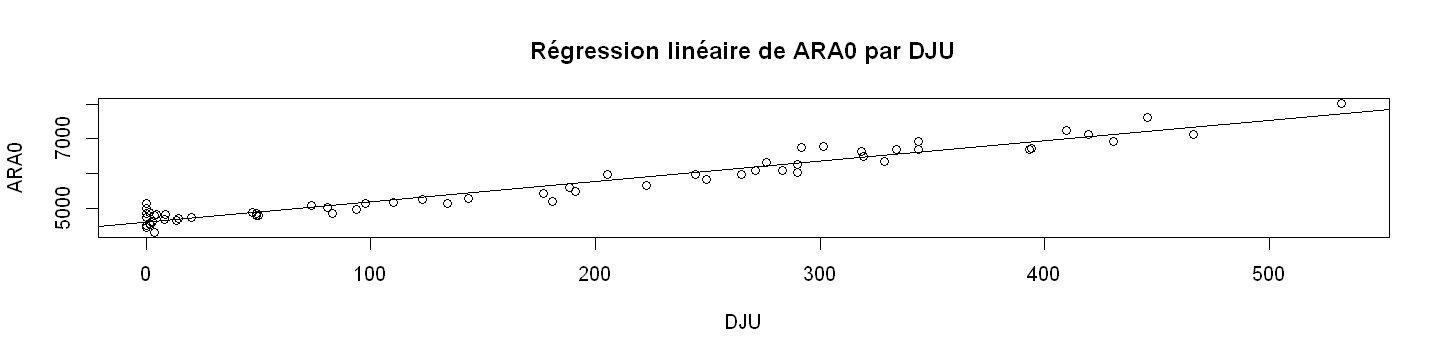

In [7]:
# Regression linéaire des deux séries
# traitement particulier pour séries temporelles (c.f. doc lm)
base = ts.intersect(ARA0, DJU, dframe=TRUE) %>% na.omit
reg = lm(base, na.action=NULL)

plot(as.numeric(DJU),as.numeric(ARA0),xlab="DJU",ylab="ARA0",main="Régression linéaire de ARA0 par DJU")
abline(reg)
cbind("R2",round(summary(reg)$r.squared,2))

# On soustrait les résidus à la série
# res <- ts(residuals(reg),frequency=12,start=c(2013, 12), end=c(2018,12))
# ARA2 <- ARA0 - res
b = reg$coefficients[2]
effet_temp = ts(DJU*b,frequency=12,start=c(2013, 12), end=c(2018,12))
ARA2 = ARA0 - effet_temp

# Note : en pratique la régression linéaire n'est pas la méthode utilisée pour pondérer la consommation
# c.f. http://www.gpso-energie.fr/conseils/analyser-ses-consommations-dju 
# Consommations corrigées = consommations x (DJU de référence/DJU de la période de consommation considérée)

## Consommation électrique corrigée de l'effet de température, de Janvier 2014 à décembre 2018

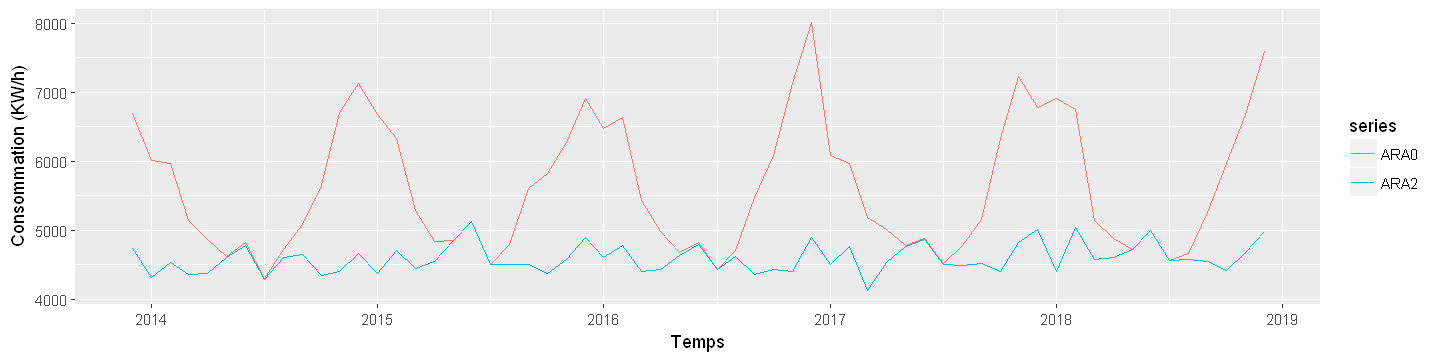

In [8]:
autoplot(cbind(ARA0,ARA2),xlab="Temps",ylab="Consommation (KW/h)")

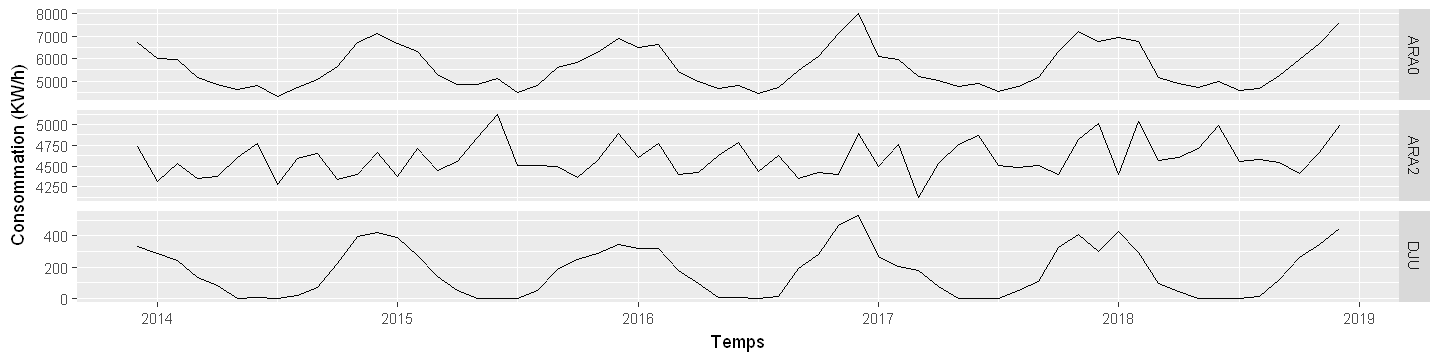

In [9]:
autoplot(cbind(ARA0,ARA2,DJU),xlab="Temps",ylab="Consommation (KW/h)",facet=T)

<hr style="height: 2px; width: 100%; ">

# Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

Décomposition de la série ECO3 en tendance, saisonnalité et résidus

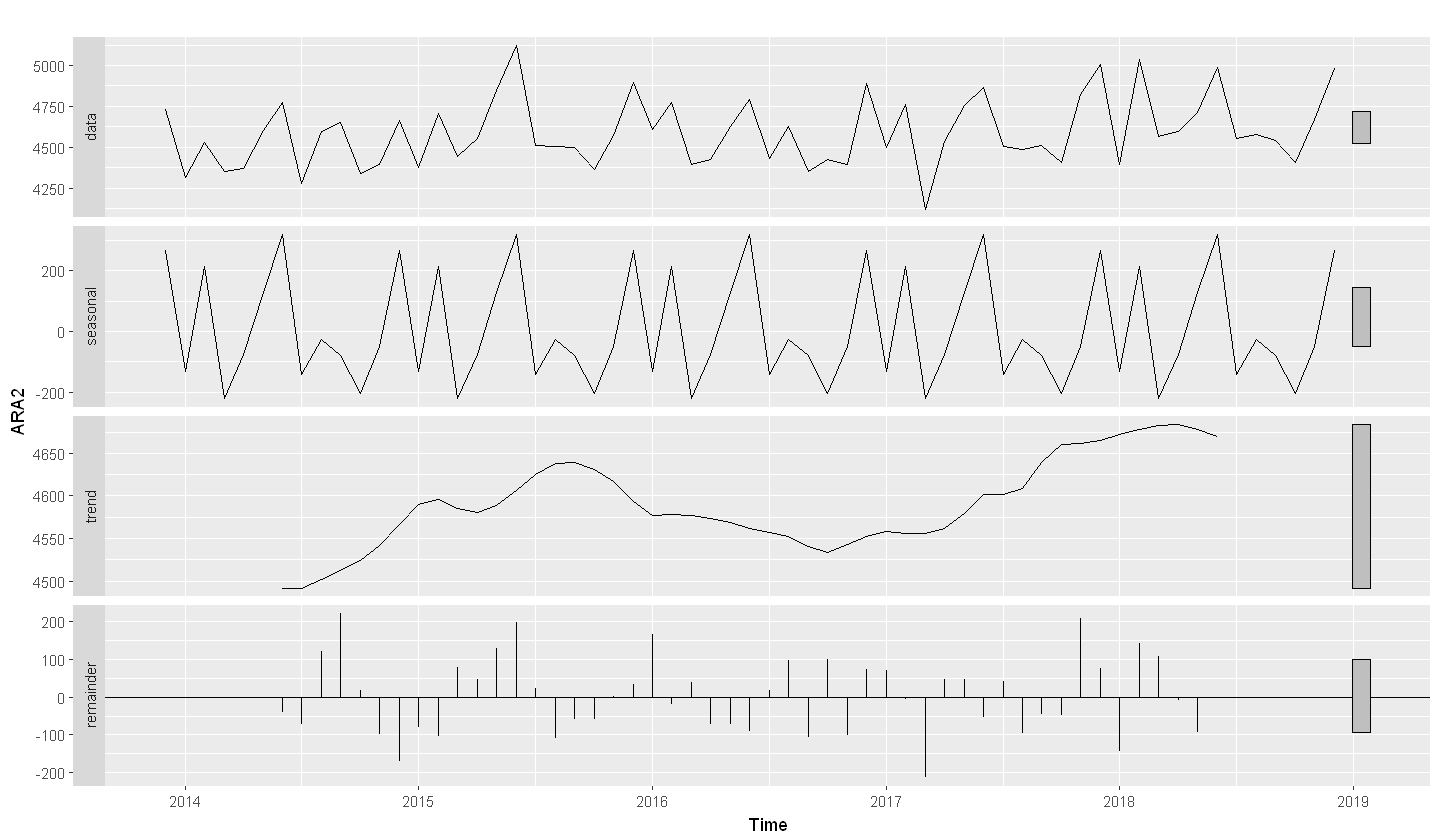

In [10]:
options(repr.plot.height=7)
autoplot(decompose(ARA2),ylab="ARA2",main="")
options(repr.plot.height=3)

### Série Stationnaire

In [11]:
ARA2

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2013                                                                        
2014 4311.662 4531.677 4352.549 4371.820 4603.406 4771.391 4277.301 4597.534
2015 4377.016 4706.768 4442.008 4551.045 4848.000 5124.000 4508.000 4502.594
2016 4608.828 4773.692 4394.128 4424.481 4625.323 4789.195 4433.241 4623.962
2017 4496.091 4764.399 4119.670 4532.722 4756.301 4867.376 4503.271 4488.045
2018 4393.851 5035.692 4567.436 4599.188 4714.241 4990.000 4552.203 4579.000
          Sep      Oct      Nov      Dec
2013                            4733.617
2014 4652.775 4336.354 4394.911 4662.775
2015 4499.925 4365.767 4570.008 4895.557
2016 4353.677 4427.715 4394.723 4892.828
2017 4512.887 4404.459 4822.663 5008.392
2018 4539.820 4408.452 4669.317 4983.948

In [12]:
options(warn = -1)
# Test de Dickey-Fuller
# Computes the Augmented Dickey-Fuller test for the null that x has a unit root.
adf.test(ARA2)
# H0 : ARA2 est stationnaire
# p-value inférieurs à 5%
options(warn = 0)


	Augmented Dickey-Fuller Test

data:  ARA2
Dickey-Fuller = -5.0627, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


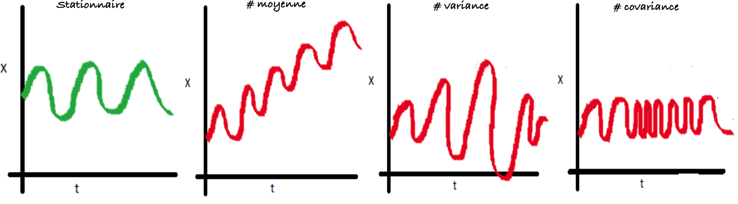

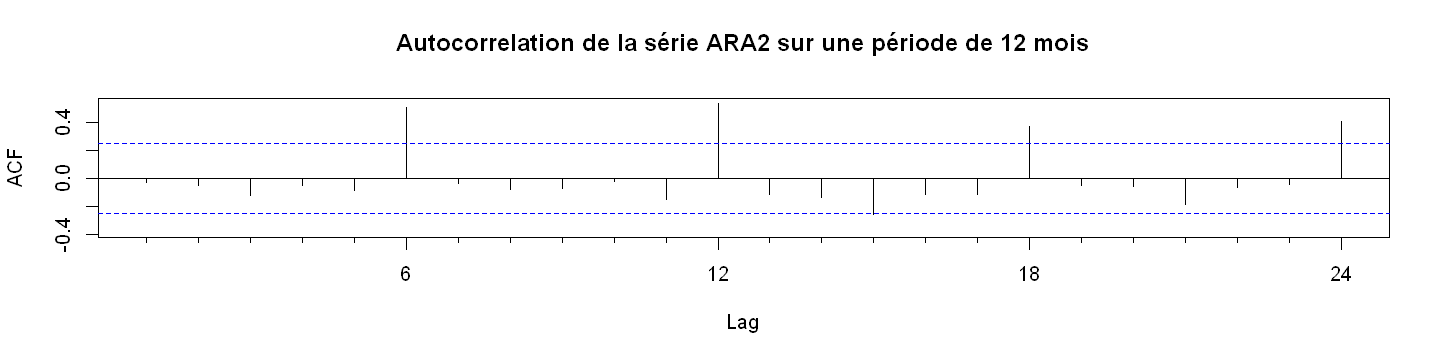

In [13]:
Acf(ARA2,main="Autocorrelation de la série ARA2 sur une période de 12 mois")

## Désaisonnalisation par les moyennes mobiles

In [14]:
MA12 = ma(ARA2, order=12)

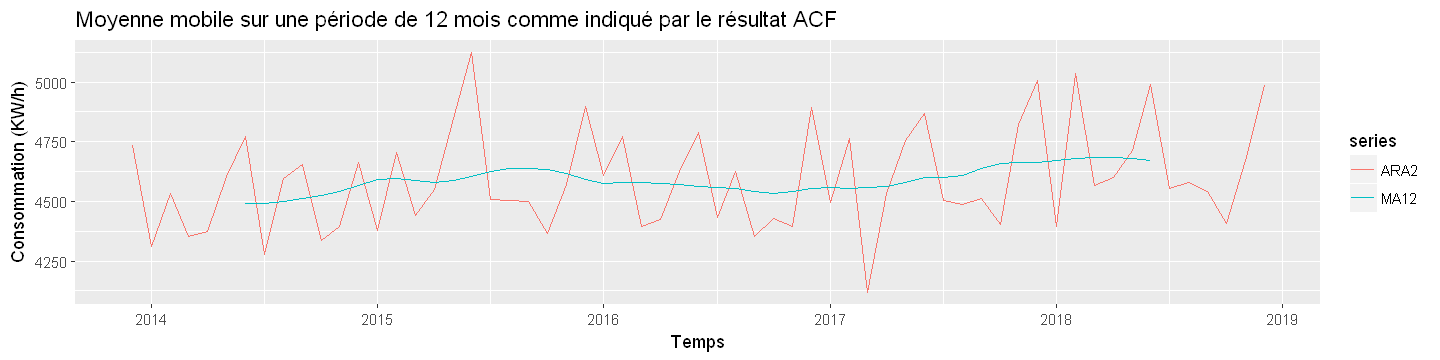

In [15]:
main="Moyenne mobile sur une période de 12 mois comme indiqué par le résultat ACF"
autoplot(cbind(ARA2,MA12),xlab="Temps",ylab="Consommation (KW/h)",main=main)

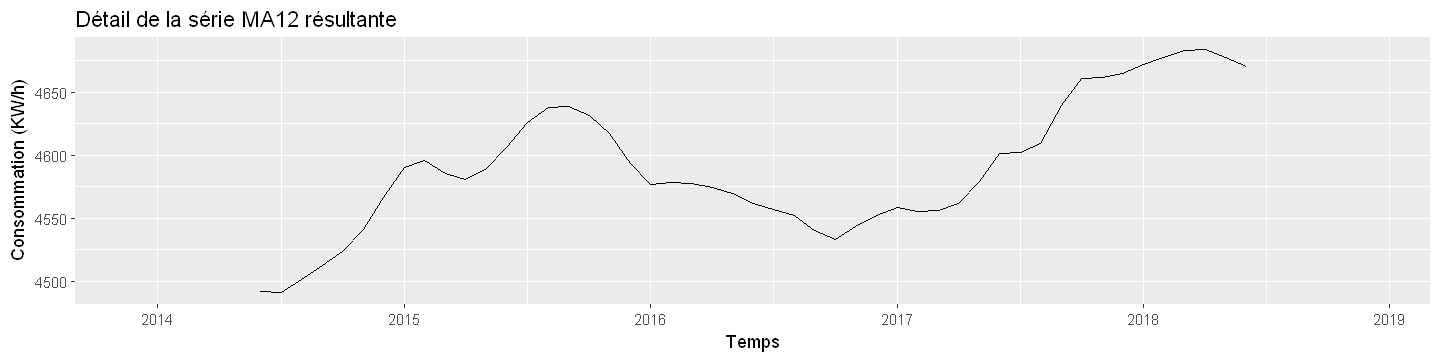

In [16]:
main="Détail de la série MA12 résultante"
autoplot(MA12,xlab="Temps",ylab="Consommation (KW/h)",main=main)

<hr style="height: 2px; width: 100%; ">

# Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

In [17]:
# From A Little Book of R For Time Series, Release 0.2
plotForecastErrors = function(forecasterrors) 
{
    forecasterrors = na.omit(forecasterrors)
    # make a histogram of the forecast errors:
    mybinsize = IQR(forecasterrors)/4
    mysd = sd(forecasterrors)
    mymin = min(forecasterrors) - mysd*5
    mymax = max(forecasterrors) + mysd*3
    # generate normally distributed data with mean 0 and standard deviation mysd
    mynorm = rnorm(10000, mean=0, sd=mysd)
    mymin2 = min(mynorm)
    mymax2 = max(mynorm)
    if (mymin2 < mymin) { mymin <- mymin2 }
    if (mymax2 > mymax) { mymax <- mymax2 }
    # make a red histogram of the forecast errors, with the normally distributed data overlaid:
    mybins = seq(mymin, mymax, mybinsize)
    hist(forecasterrors, col="red", freq=FALSE, breaks=mybins)
    # freq=FALSE ensures the area under the histogram = 1
    # generate normally distributed data with mean 0 and standard deviation mysd
    myhist <- hist(mynorm, plot=FALSE, breaks=mybins)
    # plot the normal curve as a blue line on top of the histogram of forecast errors:
    points(myhist$mids, myhist$density, type="l", col="blue", lwd=2)
}

### Triple lissage expontentiel de Holt-Winters

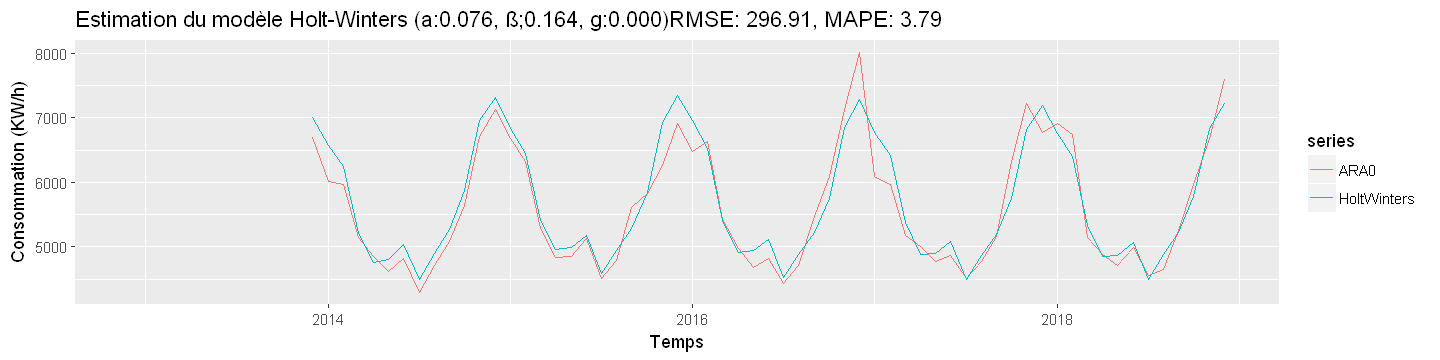

In [18]:
options(repr.plot.width=12)
HW  = forecast(HoltWinters(ARA0),12)
res = c(as.numeric(HW$fitted),as.numeric(HW$mean))
res = ts(res,frequency=12,start=c(2012, 12), end=c(2018,12))
α = HW$model$alpha
β = HW$model$beta
g = HW$model$gamma
main = sprintf("Estimation du modèle Holt-Winters (α:%.3f, β;%.3f, g:%.3f)\tRMSE: %.2f, MAPE: %.2f"
                ,α,β,g,accuracy(HW)[,"RMSE"],accuracy(HW)[,"MAPE"])
autoplot(cbind(ARA0,HoltWinters=res),xlab="Temps",ylab="Consommation (KW/h)", main=main)

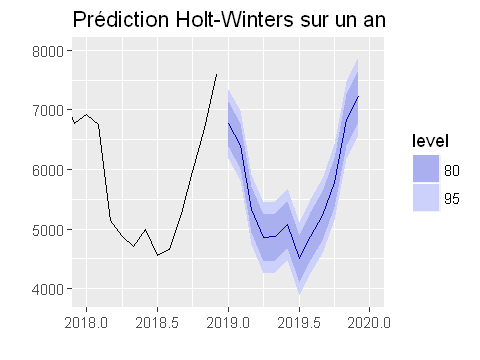

In [19]:
options(repr.plot.width=4)
HW = HoltWinters(ARA0,
                  # alpha parameter of Holt-Winters Filter.
                  alpha = α,
                  # beta parameter of Holt-Winters Filter. 
                  # If set to FALSE, the function will do exponential smoothing.
                  beta = β,
                  # gamma parameter used for the seasonal component. 
                  # If set to FALSE, an non-seasonal model is fitted.
                  gamma = g,
                  #seasonal = "additive",
                  #start.periods = 12, l.start = NULL, b.start = NULL, s.start = NULL,
                  #optim.start = c(alpha = 0.3, beta = 0.1, gamma = 0.1),
                  #optim.control = list()
                  )
main = "Prédiction Holt-Winters sur un an"
res = forecast(HW,12)
res = autoplot(res,xlab="",ylab="",main=main)
res$coordinates$limits$x = c(2018,2020)
res
options(repr.plot.width=12)

Paramètre α : lissage sur les valeurs  
Paramètre β : lissage sur la tendance  
Paramètre γ(g) : lissage sur la saisonnalité

### Analyse a posteriori : test sur l'année 2018

In [20]:
# Partage de la série en training/testing
train = window(ARA0,end = c(2017,11))
test = window(ARA0,start = c(2017,12))
HoltWinters_ARA0 = forecast(HoltWinters(train, alpha=α, beta=β, gamma=g),12)

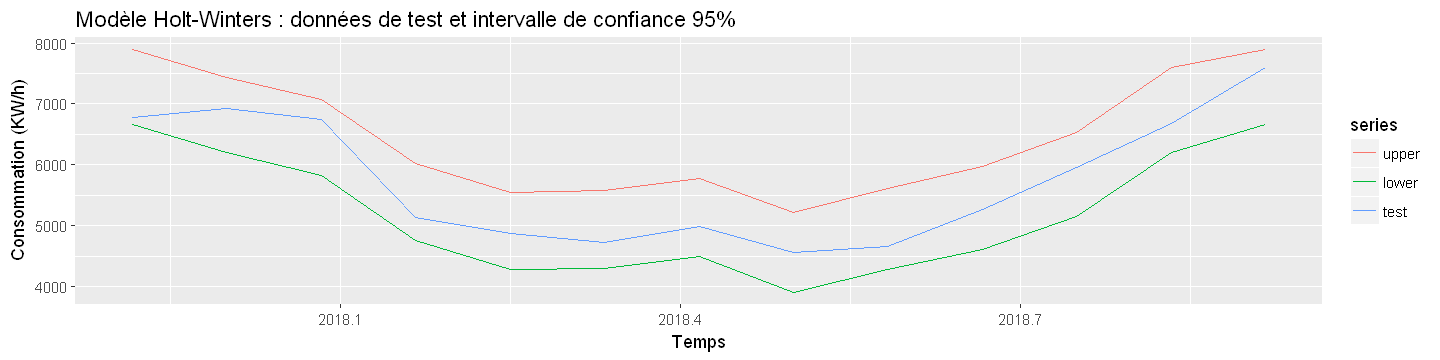

In [21]:
res = HoltWinters_ARA0
upper = ts(res$upper[,2],frequency=12,start=c(2017,12),end=c(2018,12))
lower = ts(res$lower[,2],frequency=12,start=c(2017,12),end=c(2018,12))
main="Modèle Holt-Winters : données de test et intervalle de confiance 95%"
autoplot(cbind(upper,lower,test),xlab="Temps",ylab="Consommation (KW/h)", main=main)

In [22]:
accuracy(HoltWinters_ARA0, test, d=12, D=1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-39.17760,314.5419,233.6886,-0.9337395,3.968894,0.0011008306,0.2596610,NA
Test set,-96.64464,227.0934,182.2449,-1.8748125,3.175741,0.0008584959,-0.2280529,0.3137131


In [23]:
shapiro.test(HoltWinters_ARA0$residuals)
print("H0:normality")
Box.test(HoltWinters_ARA0$residuals, lag=12, type="Ljung-Box")
print("H0:independence")


	Shapiro-Wilk normality test

data:  HoltWinters_ARA0$residuals
W = 0.97504, p-value = 0.578


[1] "H0:normality"



	Box-Ljung test

data:  HoltWinters_ARA0$residuals
X-squared = 10.974, df = 12, p-value = 0.5311


[1] "H0:independence"


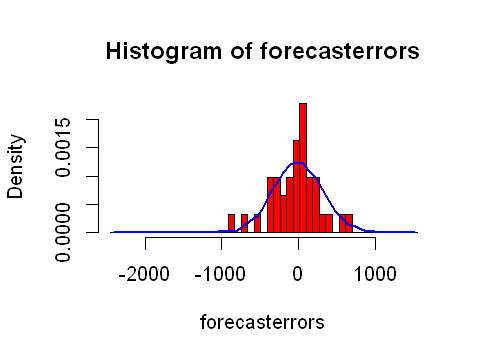

In [24]:
options(repr.plot.width=4)
plotForecastErrors(HoltWinters_ARA0$residuals)
options(repr.plot.width=12)

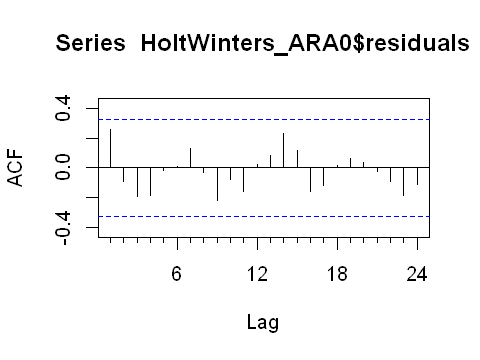

In [25]:
options(repr.plot.width=4)
Acf(HoltWinters_ARA0$residuals)
options(repr.plot.width=12)

## Modèle SARIMA

In [26]:
# Recommandations de la documentation pour trouver les paramètres optimaux
SARIMA = auto.arima(ARA0, stepwise=FALSE, approximation=FALSE, parallel=TRUE)
SARIMA

Series: ARA0 
ARIMA(0,0,1)(1,1,1)[12]                    

Coefficients:
         ma1     sar1     sma1
      0.4015  -0.3438  -0.6979
s.e.  0.1710   0.1949   0.3621

sigma^2 estimated as 77805:  log likelihood=-351.09
AIC=710.18   AICc=711.09   BIC=717.75

In [27]:
#Des résultats de auto.arima
order=c(0,0,1)
seasonal=c(1,1,1)

<b>order</b> Spécification de la partie non saisonnière du modèle ARIMA: les trois composantes (p, d, q) sont l'ordre AR, le degré de différenciation et l'ordre MA

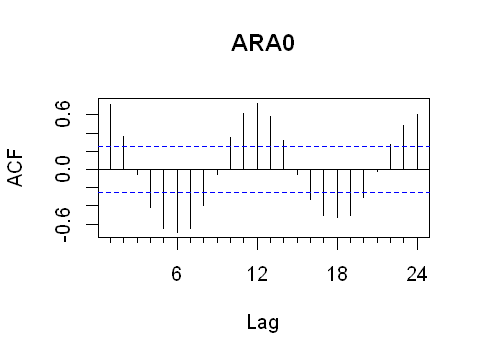

In [28]:
options(repr.plot.width=4)
Acf(ARA0,main="ARA0")
options(repr.plot.width=12)

<b>seasonal</b> Spécification de la partie saisonnière du modèle ARIMA, plus la période (qui utilise par défaut la fréquence (y))

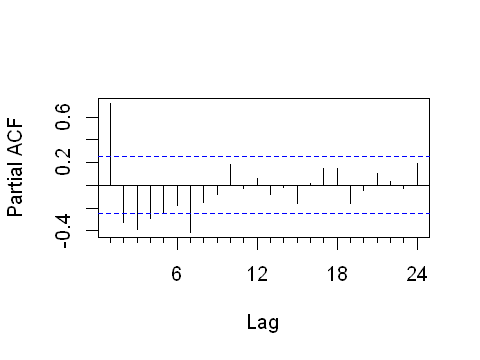

In [29]:
options(repr.plot.width=4)
Pacf(ARA0,main="")
options(repr.plot.width=12)

auto.arima(ARA0, stepwise=FALSE, approximation=FALSE, parallel=TRUE)

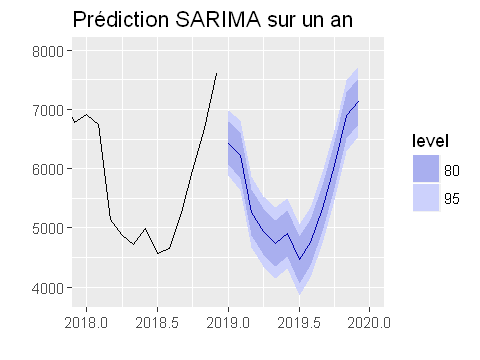

In [30]:
options(repr.plot.width=4)
main = "Prédiction SARIMA sur un an"
res = forecast(SARIMA,12)
res = autoplot(res,xlab="",ylab="",main=main)
res$coordinates$limits$x <- c(2018,2020)
res
options(repr.plot.width=12)

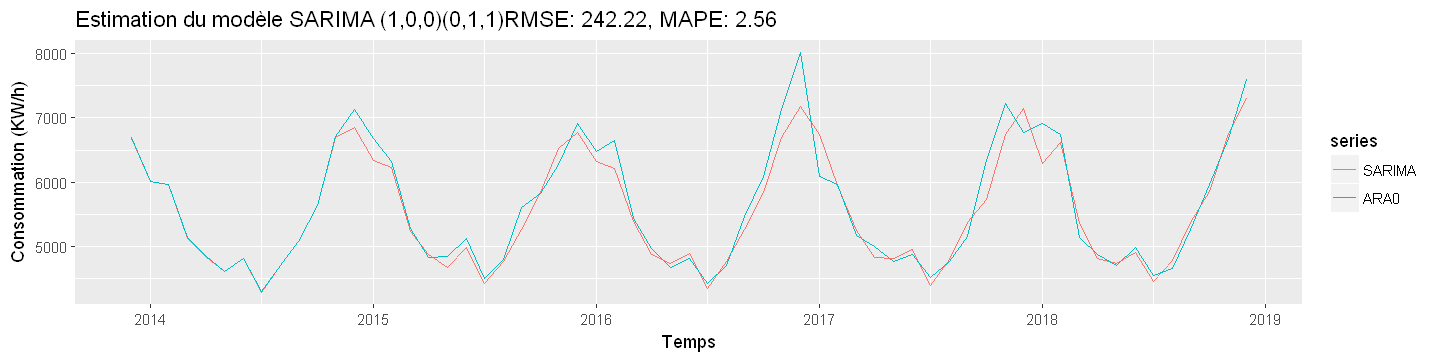

In [31]:
res = forecast(SARIMA,12)
res = c(as.numeric(res$fitted),as.numeric(res$mean))
res = ts(res,frequency=12,start=c(2013,12),end=c(2018,12))
main = sprintf("Estimation du modèle SARIMA (1,0,0)(0,1,1)\tRMSE: %.2f, MAPE: %.2f",
                accuracy(SARIMA)[,"RMSE"],accuracy(SARIMA)[,"MAPE"])
autoplot(cbind(SARIMA=res,ARA0),xlab="Temps",ylab="Consommation (KW/h)", main=main)

### Analyse a posteriori : test sur l'année 2018

In [32]:
# Partage de la série en training/testing
train = window(ARA0,end = c(2017,11))
test = window(ARA0,start = c(2017,12))
SARIMA = forecast(Arima(train,order=order,seasonal=seasonal),12)

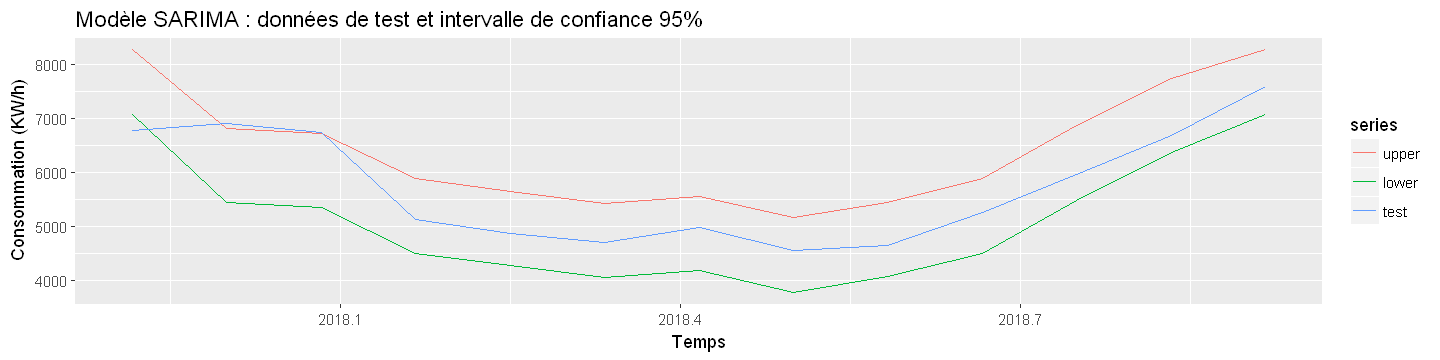

In [33]:
res = SARIMA
upper = ts(res$upper[,2],frequency=12,start=c(2017,12),end=c(2018,12))
lower = ts(res$lower[,2],frequency=12,start=c(2017,12),end=c(2018,12))
main="Modèle SARIMA : données de test et intervalle de confiance 95%"
autoplot(cbind(upper,lower,test),xlab="Temps",ylab="Consommation (KW/h)", main=main)

In [34]:
accuracy(SARIMA, test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,56.348227,237.1601,147.5592,0.8255733,2.455459,0.5361456,-0.01845734,NA
Test set,-3.179407,424.6450,294.4193,-0.1304756,4.639489,1.0697511,-0.05664339,0.5068961


In [35]:
shapiro.test(SARIMA$residuals)
print("H0:normality")
Box.test(SARIMA$residuals, fitdf=1+0, lag=12, type="Ljung-Box")
print("H0:independence")


	Shapiro-Wilk normality test

data:  SARIMA$residuals
W = 0.89153, p-value = 0.0003388


[1] "H0:normality"



	Box-Ljung test

data:  SARIMA$residuals
X-squared = 11.391, df = 11, p-value = 0.4111


[1] "H0:independence"


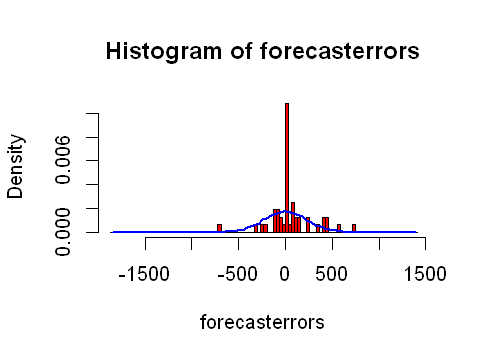

In [36]:
options(repr.plot.width=4)
plotForecastErrors(SARIMA$residuals)
options(repr.plot.width=12)

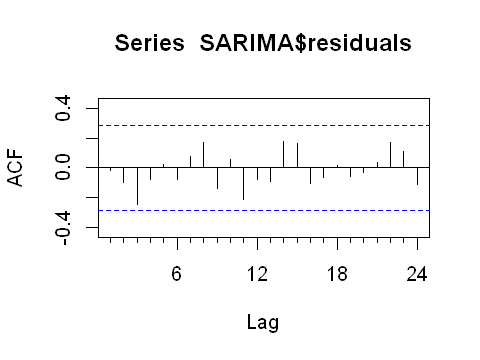

In [37]:
options(repr.plot.width=4)
Acf(SARIMA$residuals)
options(repr.plot.width=12)